In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  


In [4]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions



In [5]:
file_path = 'data_input_auto/美国RBOB汽油裂解.xlsx'
excel_data = pd.ExcelFile(file_path)
sheet = excel_data.parse('Sheet1')
sheet.rename(columns={'DataTime': 'Date'}, inplace=True)

sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet.set_index('Date', inplace=True)






full_date_range = pd.date_range(start=sheet.index.min(), end=sheet.index.max(), freq='D')
sheet_daily = sheet.reindex(full_date_range)
sheet_daily.reset_index(inplace=True)
sheet_daily.rename(columns={'index': 'Date'}, inplace=True)

fill_methods = {
    '美国2年通胀预期': 'rolling_mean_5',    
    '美国首次申领失业金人数/4WMA': 'interpolate' ,  
    '道琼斯旅游与休闲/工业平均指数': 'interpolate',
    '美国EIA成品油总库存(预测/供应需求3年季节性)': 'interpolate',
    '美国成品车用汽油倒推产量（预测/汽油库存维持上年季节性）/8WMA':'interpolate',
    '美国成品车用汽油炼厂与调和装置净产量/4WMA(预测/上年季节性)超季节性/5年':'interpolate',
    '美国炼厂可用产能（路透）(预测)': 'interpolate',
    '美国炼厂CDU装置检修量（新）':'interpolate',
    '美湾单位辛烷值价格(预测/季节性)':'interpolate',
    '美国炼厂可用产能（路透）(预测)':'interpolate',
    '美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年': 'interpolate'
} 
sheet_daily = fill_missing_values(sheet_daily, fill_methods, return_only_filled=False)

sheet_daily['美国2年通胀预期_提前70天'] = sheet_daily['美国2年通胀预期'].shift(70)
sheet_daily['美国首次申领失业金人数/4WMA_提前140天'] = sheet_daily['美国首次申领失业金人数/4WMA'].shift(140)
sheet_daily['美国首次申领失业金人数/4WMA_提前112天'] = sheet_daily['美国首次申领失业金人数/4WMA'].shift(112)
sheet_daily['道琼斯旅游与休闲/工业平均指数_提前14天'] = sheet_daily['道琼斯旅游与休闲/工业平均指数'].shift(14)
sheet_daily['美国EIA成品油总库存(预测/供应需求3年季节性)_提前40天'] = sheet_daily['美国EIA成品油总库存(预测/供应需求3年季节性)'].shift(40)
sheet_daily['美国成品车用汽油炼厂与调和装置净产量/4WMA(预测/上年季节性)超季节性/5年_提前30天'] = sheet_daily['美国成品车用汽油炼厂与调和装置净产量/4WMA(预测/上年季节性)超季节性/5年'].shift(30)
sheet_daily['美国炼厂CDU装置检修量（新）_提前30天'] = sheet_daily['美国炼厂CDU装置检修量（新）'].shift(30)
sheet_daily['美国炼厂可用产能（路透）(预测)_提前100天'] = sheet_daily['美国炼厂可用产能（路透）(预测)'].shift(100)

last_day = sheet_daily['Date'].iloc[sheet_daily['美国RBOB汽油裂解'].last_valid_index()]
last_day_2 = sheet_daily['Date'].iloc[sheet_daily['美国RBOB汽油裂解'].last_valid_index()] + pd.Timedelta(days=30)
sheet_daily = sheet_daily[(sheet_daily['Date'] >= '2009-08-01') & (sheet_daily['Date'] <= last_day_2)]
#sheet_daily = sheet_daily[(sheet_daily['Date'] >= '2022-01-01') & (sheet_daily['Date'] <= last_day_2)]
# 获取工作日日期范围
sheet_daily = sheet_daily[sheet_daily['Date'].dt.dayofweek < 5]  # 0-4 代表周一至周五



# 进行逆序处理
sheet_daily['美国首次申领失业金人数/4WMA_逆序'] = reverse_column(sheet_daily, '美国首次申领失业金人数/4WMA')
sheet_daily['美国首次申领失业金人数/4WMA_提前140天_逆序'] = reverse_column(sheet_daily, '美国首次申领失业金人数/4WMA_提前140天')
sheet_daily['美国首次申领失业金人数/4WMA_提前112天_逆序'] = reverse_column(sheet_daily, '美国首次申领失业金人数/4WMA_提前112天')
sheet_daily['美国EIA成品油总库存(预测/供应需求3年季节性)_逆序'] = reverse_column(sheet_daily, '美国EIA成品油总库存(预测/供应需求3年季节性)')
sheet_daily['美国EIA成品油总库存(预测/供应需求3年季节性)_提前40天_逆序'] = reverse_column(sheet_daily, '美国EIA成品油总库存(预测/供应需求3年季节性)_提前40天')
sheet_daily['美国炼厂可用产能（路透）(预测)_逆序'] = reverse_column(sheet_daily, '美国炼厂可用产能（路透）(预测)_提前100天')
sheet_daily['美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年_逆序'] = reverse_column(sheet_daily, '美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年')

sheet_daily['美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年_逆序_2022-01-01'] = np.where(
    sheet_daily['Date'] >= pd.Timestamp('2022-01-01'),
    sheet_daily['美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年_逆序'],
    np.nan
)


sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['美国RBOB汽油裂解'].notna()]

In [6]:
sheet.columns

Index(['美国RBOB汽油裂解', '道琼斯旅游与休闲/工业平均指数', '美国2年通胀预期', '美国首次申领失业金人数/4WMA',
       '美国EIA成品油总库存(预测/供应需求3年季节性)', '美国成品车用汽油倒推产量（预测/汽油库存维持上年季节性）/8WMA',
       '美国成品车用汽油炼厂与调和装置净产量/4WMA(预测/上年季节性)超季节性/5年', '美国炼厂CDU装置检修量（新）',
       '美国炼厂可用产能（路透）(预测)', '美湾单位辛烷值价格(预测/季节性)',
       '美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年'],
      dtype='object')

In [7]:
last_day 

Timestamp('2025-10-31 00:00:00')

In [8]:
sheet_daily.columns

Index(['Date', '美国RBOB汽油裂解', '美国2年通胀预期', '美国首次申领失业金人数/4WMA', '道琼斯旅游与休闲/工业平均指数',
       '美国EIA成品油总库存(预测/供应需求3年季节性)', '美国成品车用汽油倒推产量（预测/汽油库存维持上年季节性）/8WMA',
       '美国成品车用汽油炼厂与调和装置净产量/4WMA(预测/上年季节性)超季节性/5年', '美国炼厂可用产能（路透）(预测)',
       '美国炼厂CDU装置检修量（新）', '美湾单位辛烷值价格(预测/季节性)',
       '美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年', '美国2年通胀预期_提前70天',
       '美国首次申领失业金人数/4WMA_提前140天', '美国首次申领失业金人数/4WMA_提前112天',
       '道琼斯旅游与休闲/工业平均指数_提前14天', '美国EIA成品油总库存(预测/供应需求3年季节性)_提前40天',
       '美国成品车用汽油炼厂与调和装置净产量/4WMA(预测/上年季节性)超季节性/5年_提前30天',
       '美国炼厂CDU装置检修量（新）_提前30天', '美国炼厂可用产能（路透）(预测)_提前100天',
       '美国首次申领失业金人数/4WMA_逆序', '美国首次申领失业金人数/4WMA_提前140天_逆序',
       '美国首次申领失业金人数/4WMA_提前112天_逆序', '美国EIA成品油总库存(预测/供应需求3年季节性)_逆序',
       '美国EIA成品油总库存(预测/供应需求3年季节性)_提前40天_逆序', '美国炼厂可用产能（路透）(预测)_逆序',
       '美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年_逆序',
       '美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年_逆序_2022-01-01'],
      dtype='object')

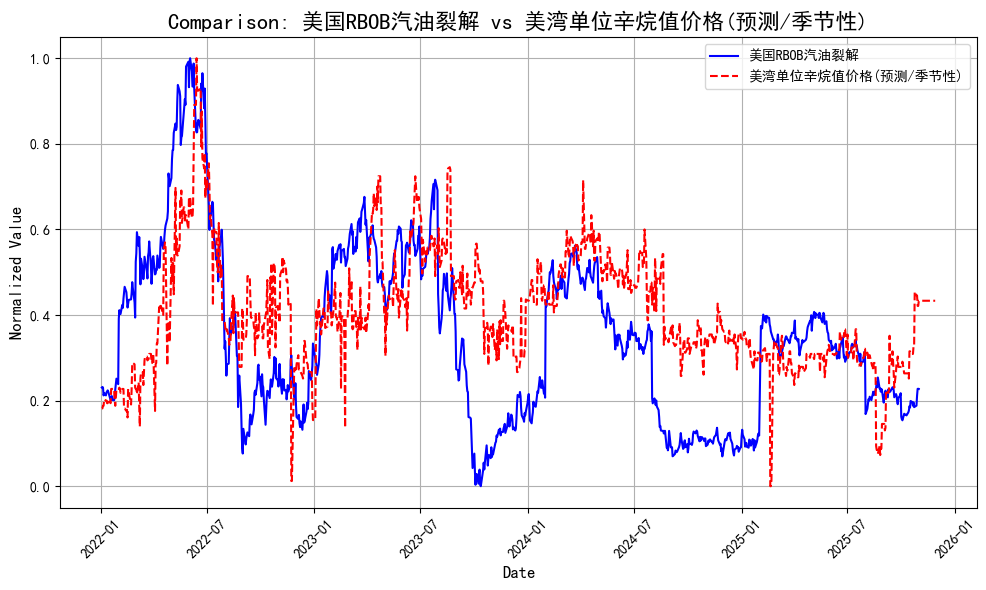

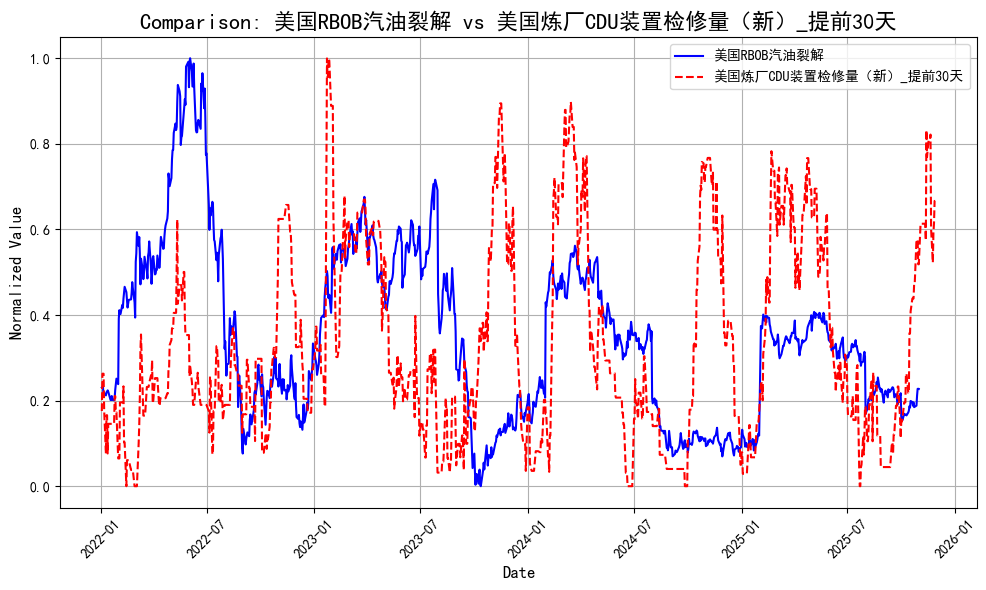

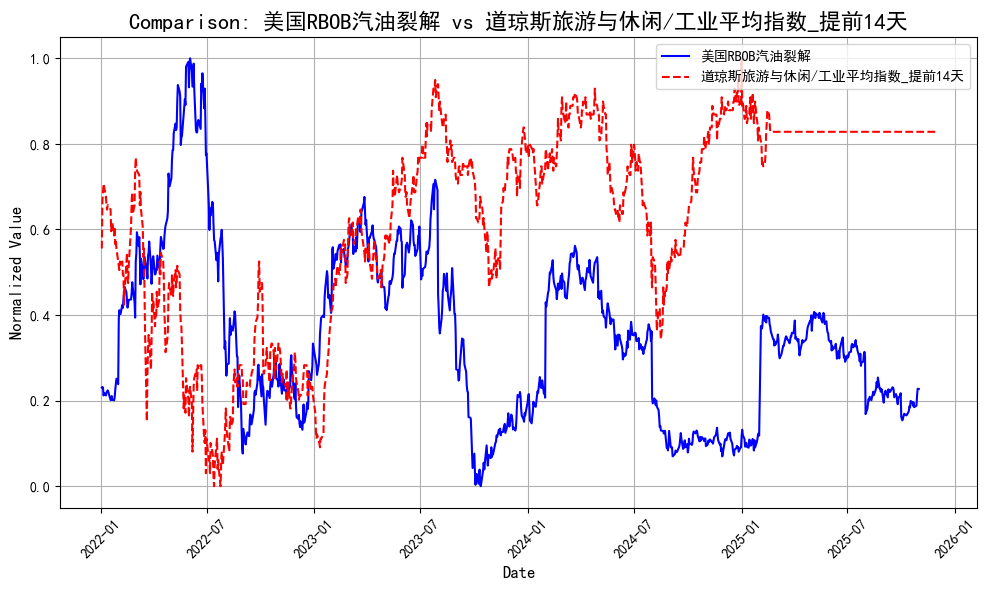

列 '美国2年通胀预期_提前56天' 不存在于 DataFrame 中。


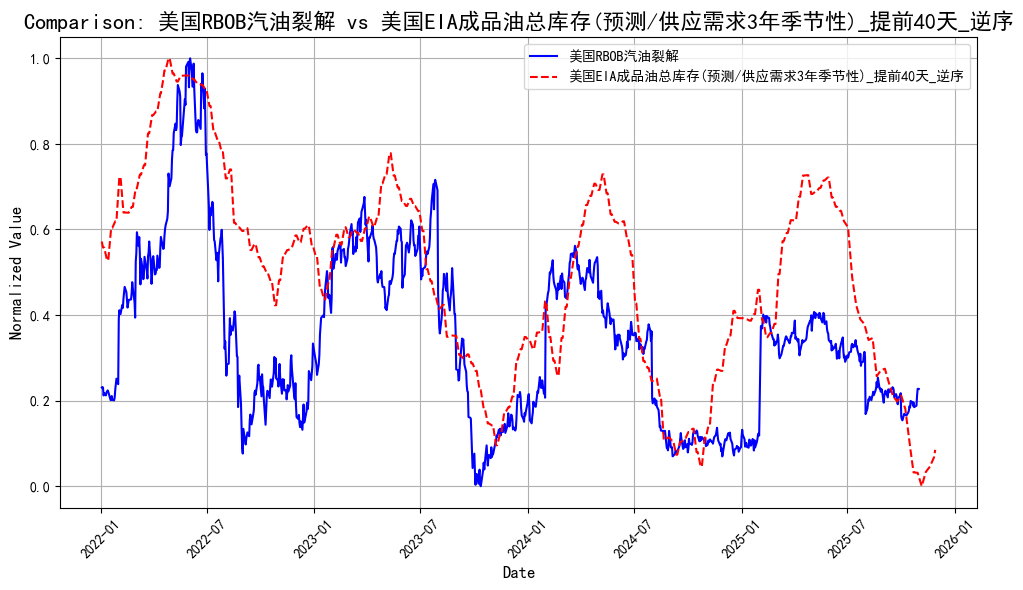

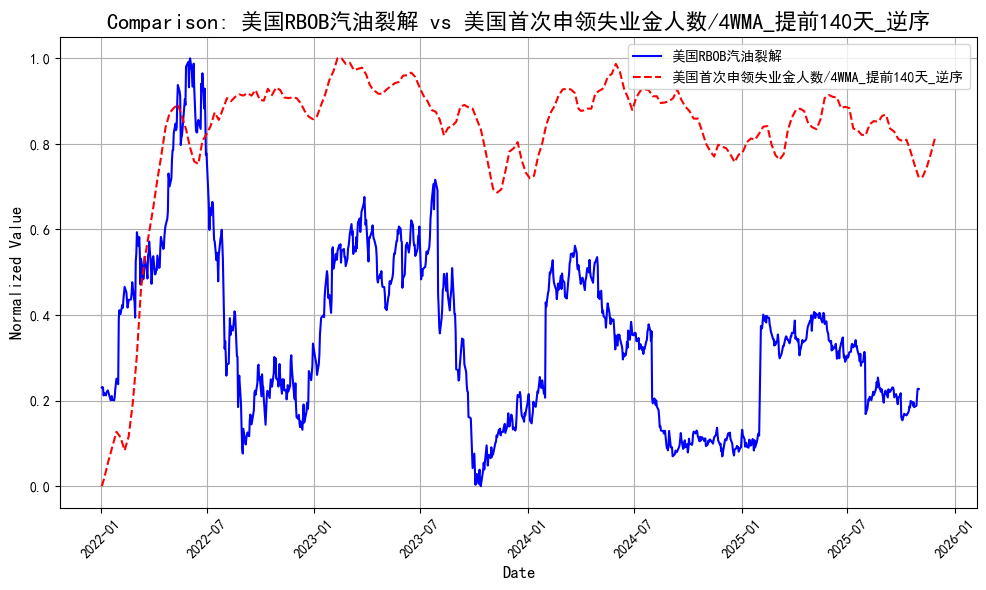

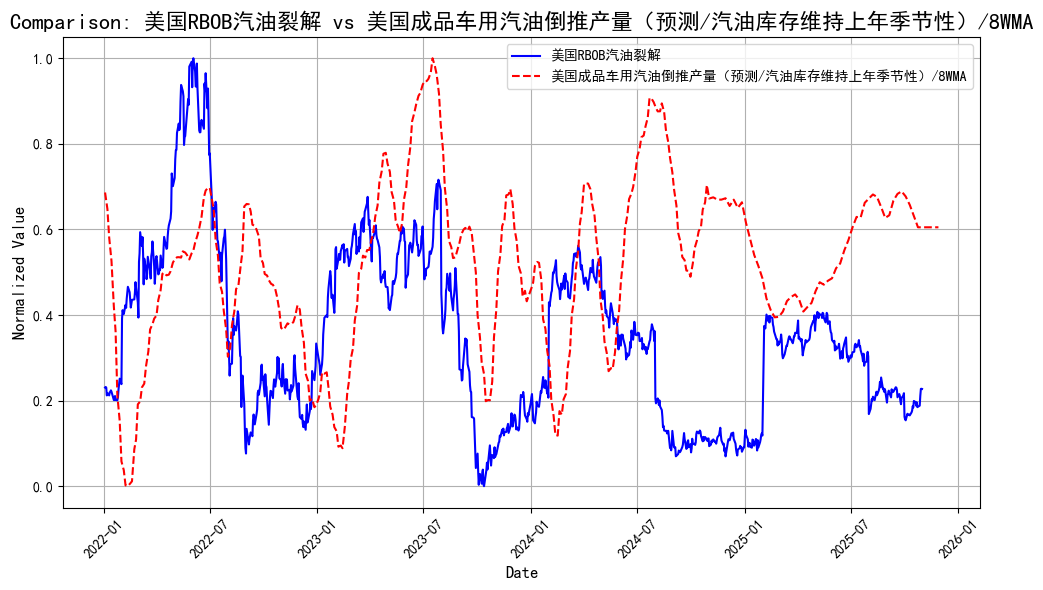

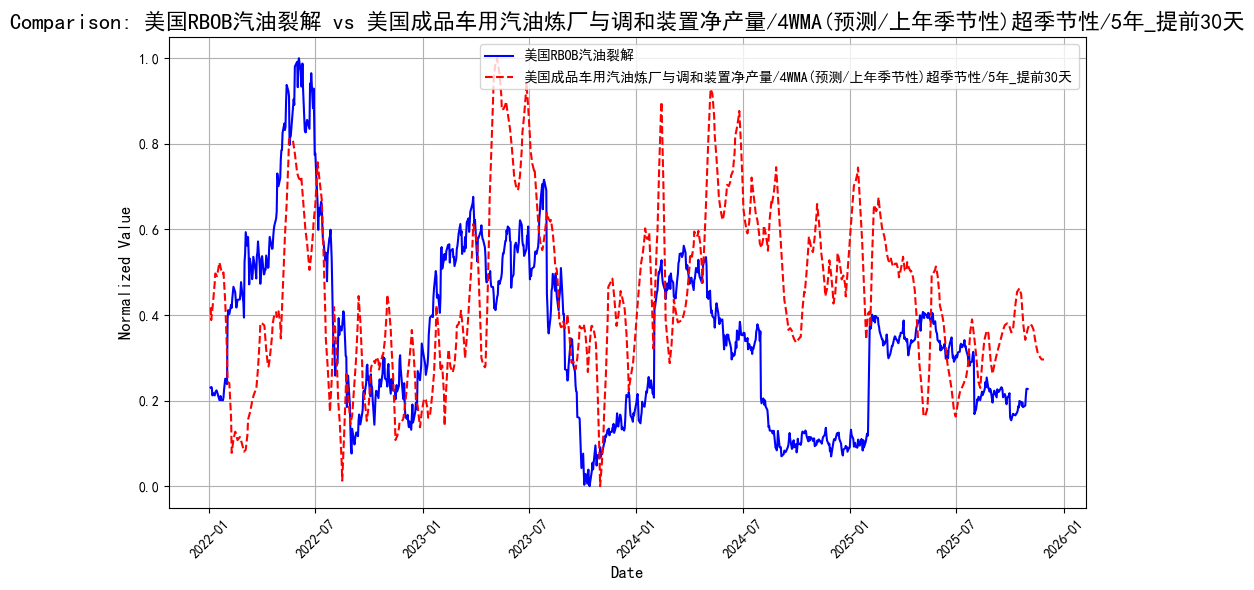

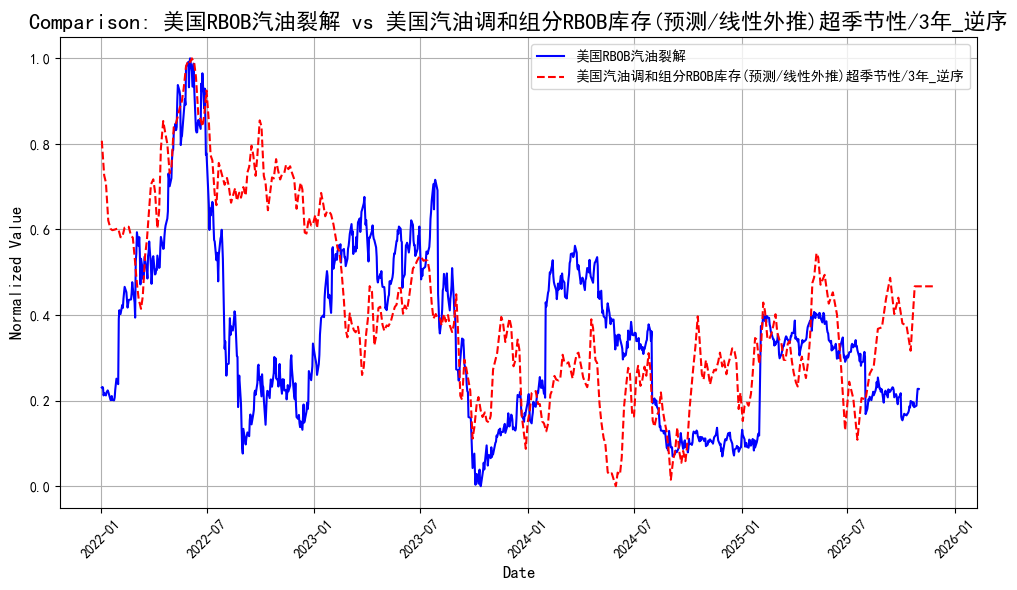

In [9]:
# 将Date列设置为索引
sheet_daily_plot = sheet_daily.set_index('Date')
# 选择2022年之前的数据
#sheet_daily_plot = sheet_daily_plot[:'2021-12-31']
# 选择2022年之后的数据
sheet_daily_plot = sheet_daily_plot['2022-01-01':]

plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='美国RBOB汽油裂解', 
    compare_cols=['美湾单位辛烷值价格(预测/季节性)',
                  '美国炼厂CDU装置检修量（新）_提前30天','道琼斯旅游与休闲/工业平均指数_提前14天', '美国2年通胀预期_提前56天',
                  '美国EIA成品油总库存(预测/供应需求3年季节性)_提前40天_逆序', '美国首次申领失业金人数/4WMA_提前140天_逆序',
                  '美国成品车用汽油倒推产量（预测/汽油库存维持上年季节性）/8WMA','美国成品车用汽油炼厂与调和装置净产量/4WMA(预测/上年季节性)超季节性/5年_提前30天',
                  '美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年_逆序'
                  ]
)

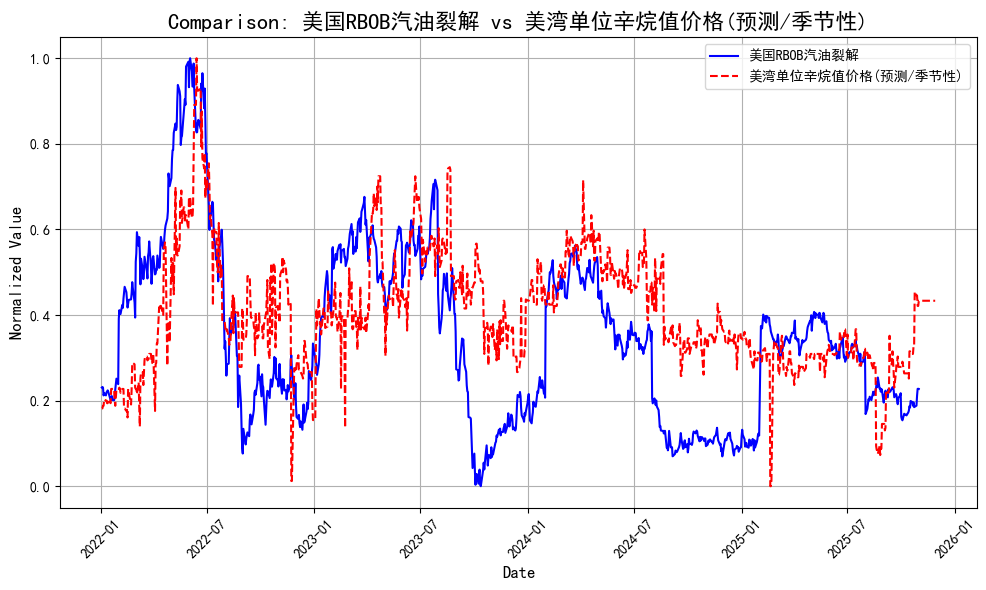

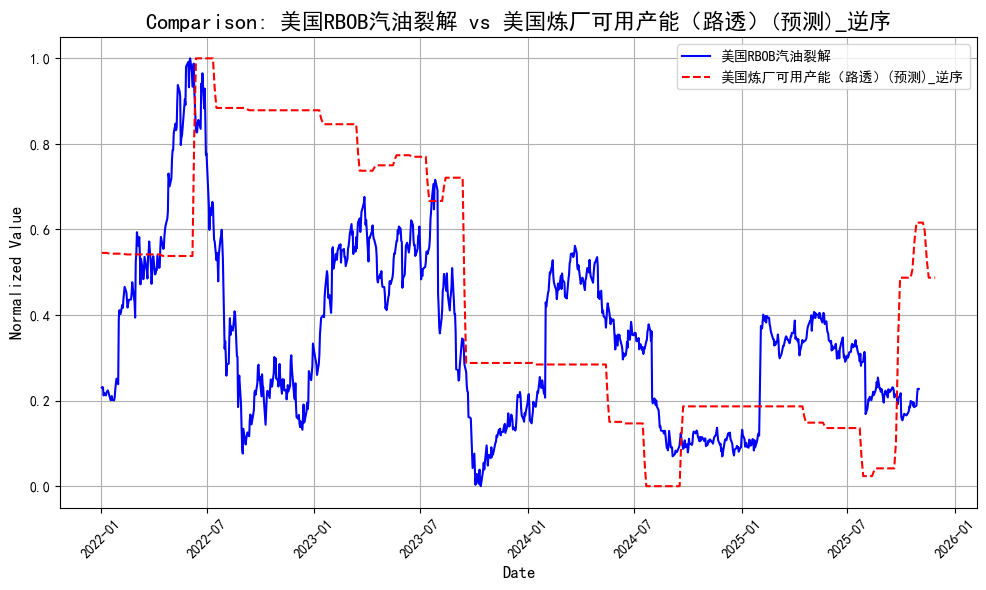

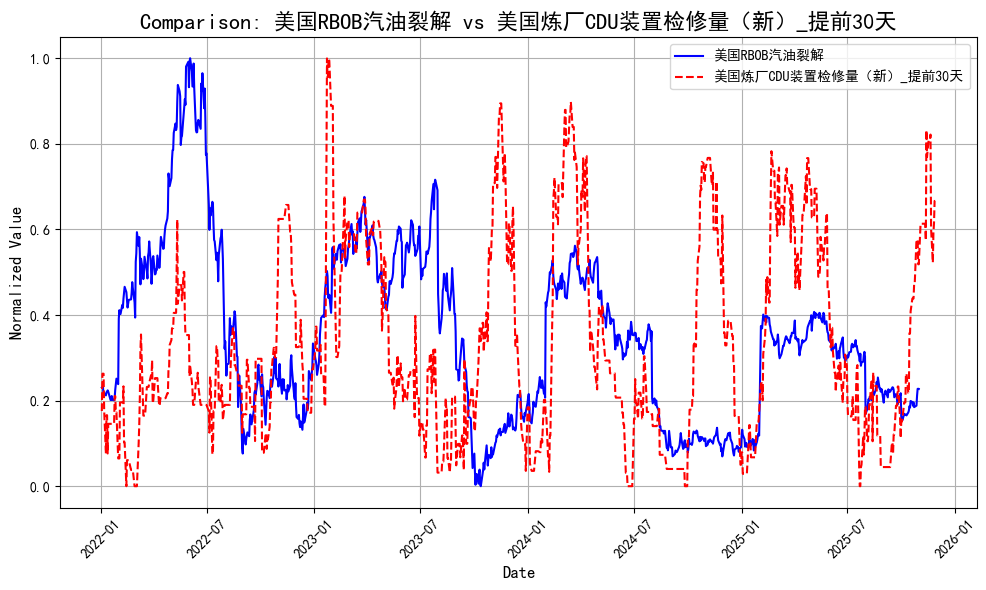

列 '美国2年通胀预期_提前56天' 不存在于 DataFrame 中。
列 '美国首次申领失业金人数/4WMA_提前120天_逆序' 不存在于 DataFrame 中。


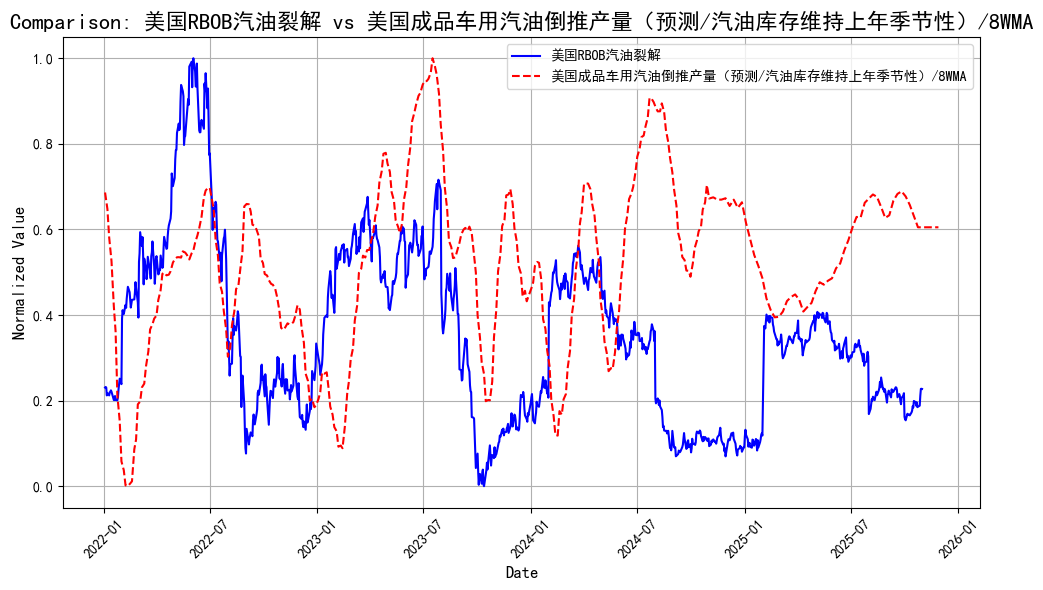

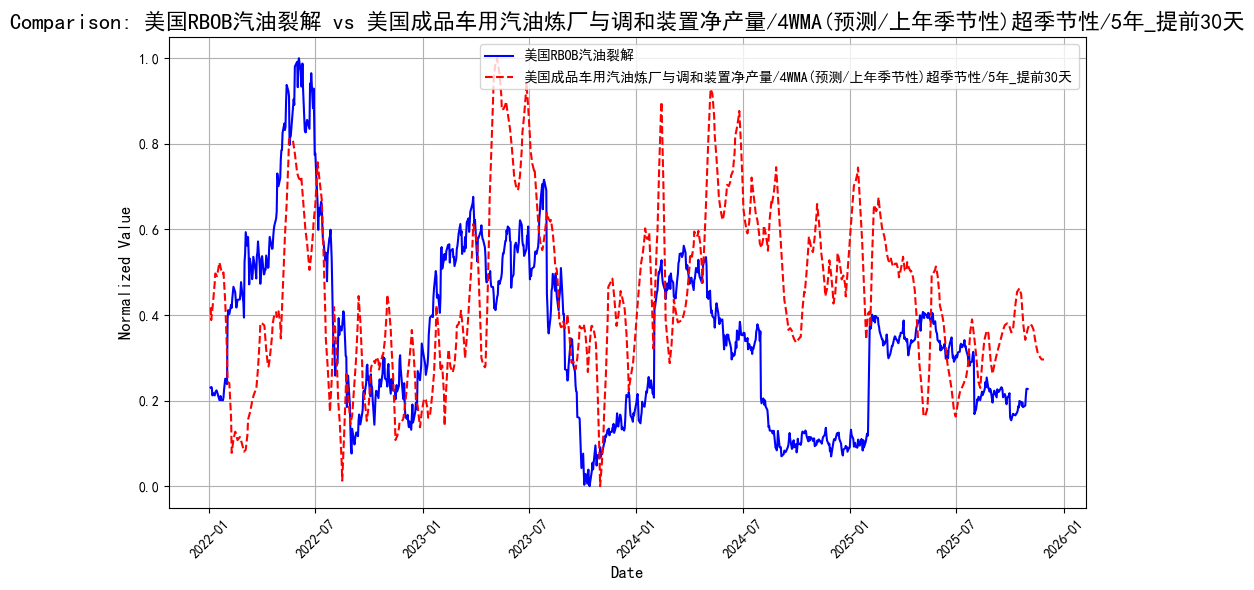

In [10]:
# 将Date列设置为索引
sheet_daily_plot = sheet_daily.set_index('Date')
# 选择2022年之前的数据
#sheet_daily_plot = sheet_daily_plot[:'2021-12-31']
# 选择2022年之后的数据
sheet_daily_plot = sheet_daily_plot['2022-01-01':]

plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='美国RBOB汽油裂解', 
    compare_cols=['美湾单位辛烷值价格(预测/季节性)','美国炼厂可用产能（路透）(预测)_逆序','美国炼厂CDU装置检修量（新）_提前30天', 
                      '美国2年通胀预期_提前56天','美国首次申领失业金人数/4WMA_提前120天_逆序',
                      '美国成品车用汽油倒推产量（预测/汽油库存维持上年季节性）/8WMA','美国成品车用汽油炼厂与调和装置净产量/4WMA(预测/上年季节性)超季节性/5年_提前30天'
                  ]
)

In [11]:
# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 3
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]


feature_columns = [
'美湾单位辛烷值价格(预测/季节性)',
'美国炼厂CDU装置检修量（新）_提前30天', 
'美国EIA成品油总库存(预测/供应需求3年季节性)_提前40天_逆序', 
'美国首次申领失业金人数/4WMA_提前140天_逆序',
'美国成品车用汽油倒推产量（预测/汽油库存维持上年季节性）/8WMA',
'美国成品车用汽油炼厂与调和装置净产量/4WMA(预测/上年季节性)超季节性/5年_提前30天',
'美国汽油调和组分RBOB库存(预测/线性外推)超季节性/3年_逆序_2022-01-01'
]


# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data['美国RBOB汽油裂解']

X_test = test_data[feature_columns]
y_test = test_data['美国RBOB汽油裂解']

X_future = future_data[feature_columns]

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

z_scores = np.abs((X_train - X_train.mean()) / X_train.std())
outlier_mask = (z_scores > 3).any(axis=1)  # Z-score 大于 3 的视为异常
weights = np.where(outlier_mask, 0.05, 1.0)   # 异常样本权重 0.1，正常样本权重 1.0

dtrain = xgb.DMatrix(X_train_scaled, label=y_train, weight=weights)  # 使用 DMatrix，并传入权重
dtest = xgb.DMatrix(X_test_scaled, label=y_test)  # 修复标签问题

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.13,
    'max_depth': 8,
    'min_child_weight': 3,
    'gamma': 0.01,
    'subsample': 0.4,
    'colsample_bytree': 0.5,
    'eval_metric': 'rmse',
    'seed': 42,
    'reg_alpha': 0.2,  # L1正则化
    'reg_lambda': 0.1,  # L2正则化
}

evals_result = {}
num_boost_round = 100 # 指定迭代次数
xgb_model_dmatrix = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, 'Train'), (dtest, 'Test')],
    evals_result=evals_result,  # 保存评估结果
    verbose_eval=False  # 关闭每轮的输出
)

# 训练集预测
y_train_pred_dmatrix = xgb_model_dmatrix.predict(dtrain)

# 测试集预测

y_test_pred_dmatrix = xgb_model_dmatrix.predict(dtest)

# 计算 MSE 和 R² 分数
train_mse_dmatrix = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse_dmatrix = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2_dmatrix = r2_score(y_train, y_train_pred_dmatrix)
test_r2_dmatrix = r2_score(y_test, y_test_pred_dmatrix)

print(f"Train MSE (DMatrix): {train_mse_dmatrix}, Train R² (DMatrix): {train_r2_dmatrix}")
print(f"Test MSE (DMatrix): {test_mse_dmatrix}, Test R² (DMatrix): {test_r2_dmatrix}")


Train MSE (DMatrix): 0.9706117757420634, Train R² (DMatrix): 0.985427766415744
Test MSE (DMatrix): 2.9106478025201548, Test R² (DMatrix): -43658.717037804185


In [13]:
# 未来预测 1
dfuture = xgb.DMatrix(X_future_scaled)
y_future_pred_dmatrix = xgb_model_dmatrix.predict(dfuture)

# 将预测结果加入到 future_data
test_data = test_data.copy()
future_data = future_data.copy()

test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

In [14]:
# 未来预测 2 
X_all = np.vstack((X_train, X_test))
y_all = np.concatenate((y_train, y_test))

# 重新标准化完整数据集
X_all_scaled = scaler.fit_transform(X_all)

# 检测完整数据集的异常值
z_scores_all = np.abs((X_all - X_all.mean()) / X_all.std())
outlier_mask_all = (z_scores_all > 3).any(axis=1)
weights_all = np.where(outlier_mask_all, 0.1, 1.0)

# 使用完整数据集重新训练模型
dtrain_all = xgb.DMatrix(X_all_scaled, label=y_all, weight=weights_all)
xgb_model_dmatrix_all = xgb.train(params, dtrain_all, num_boost_round=num_boost_round)

y_future_pred_dmatrix_all = xgb_model_dmatrix_all.predict(dfuture)

future_data['完整模型预测值'] = y_future_pred_dmatrix_all

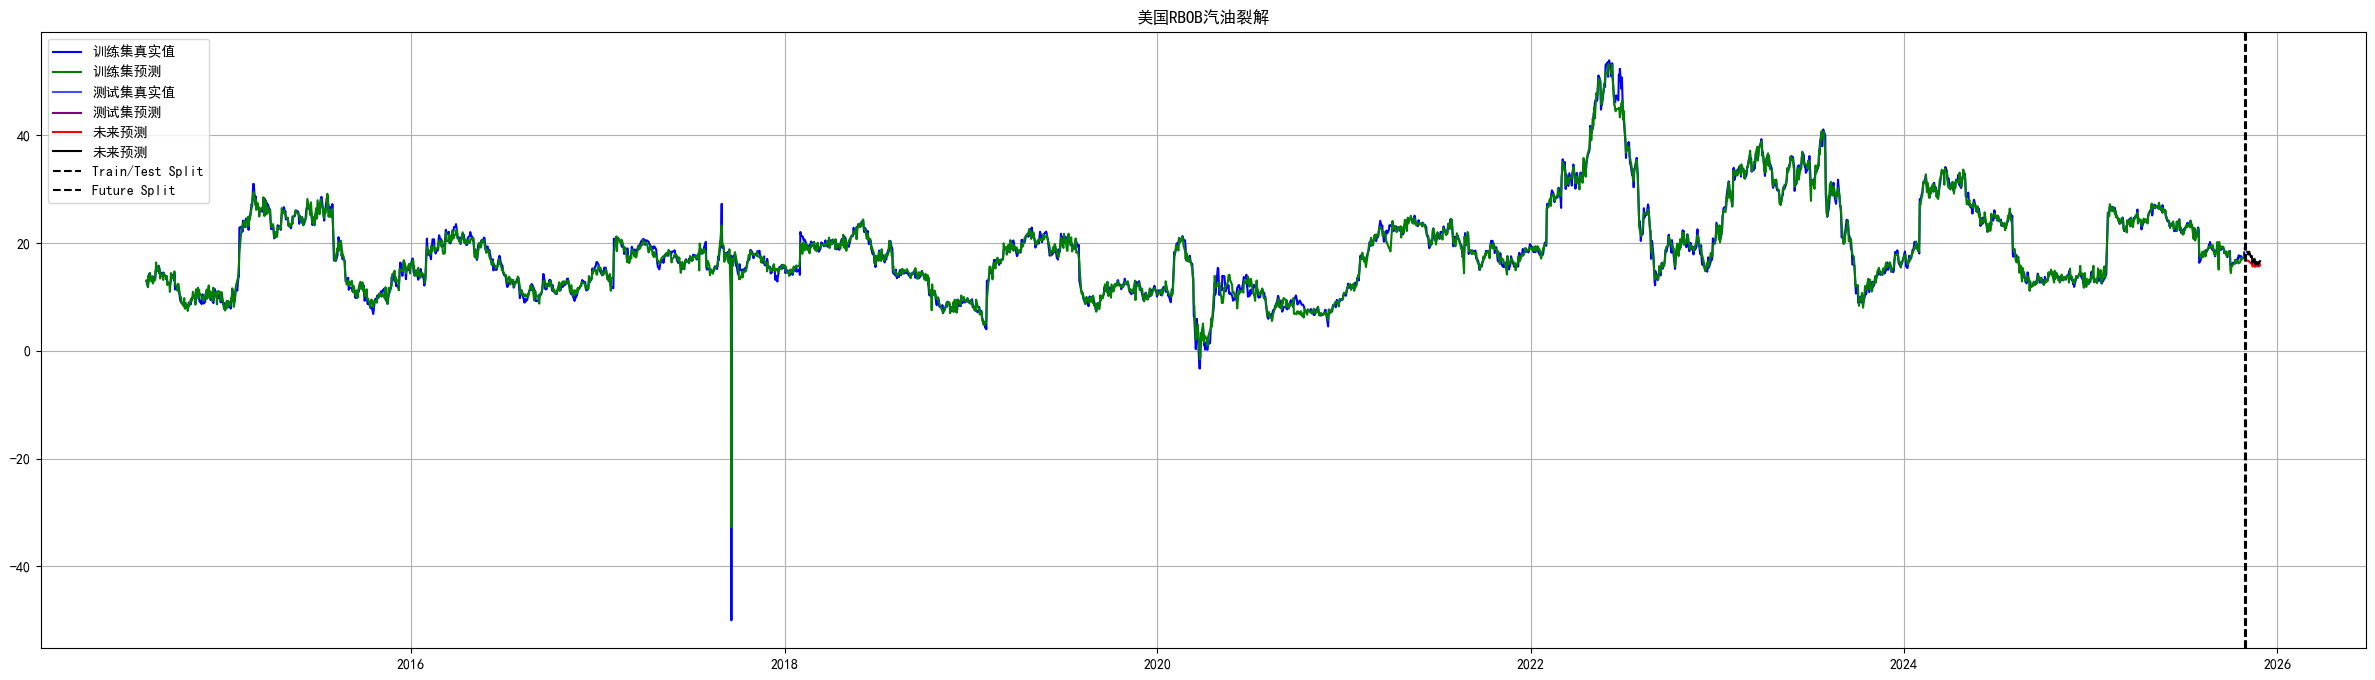

In [15]:
# 可视化
plt.figure(figsize=(30, 8))

plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集预测', color='green')

plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue',alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix , label='测试集预测', color='purple')

plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['完整模型预测值'] , label='未来预测', color='black')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('美国RBOB汽油裂解')
plt.legend()
plt.grid(True)
plt.show()

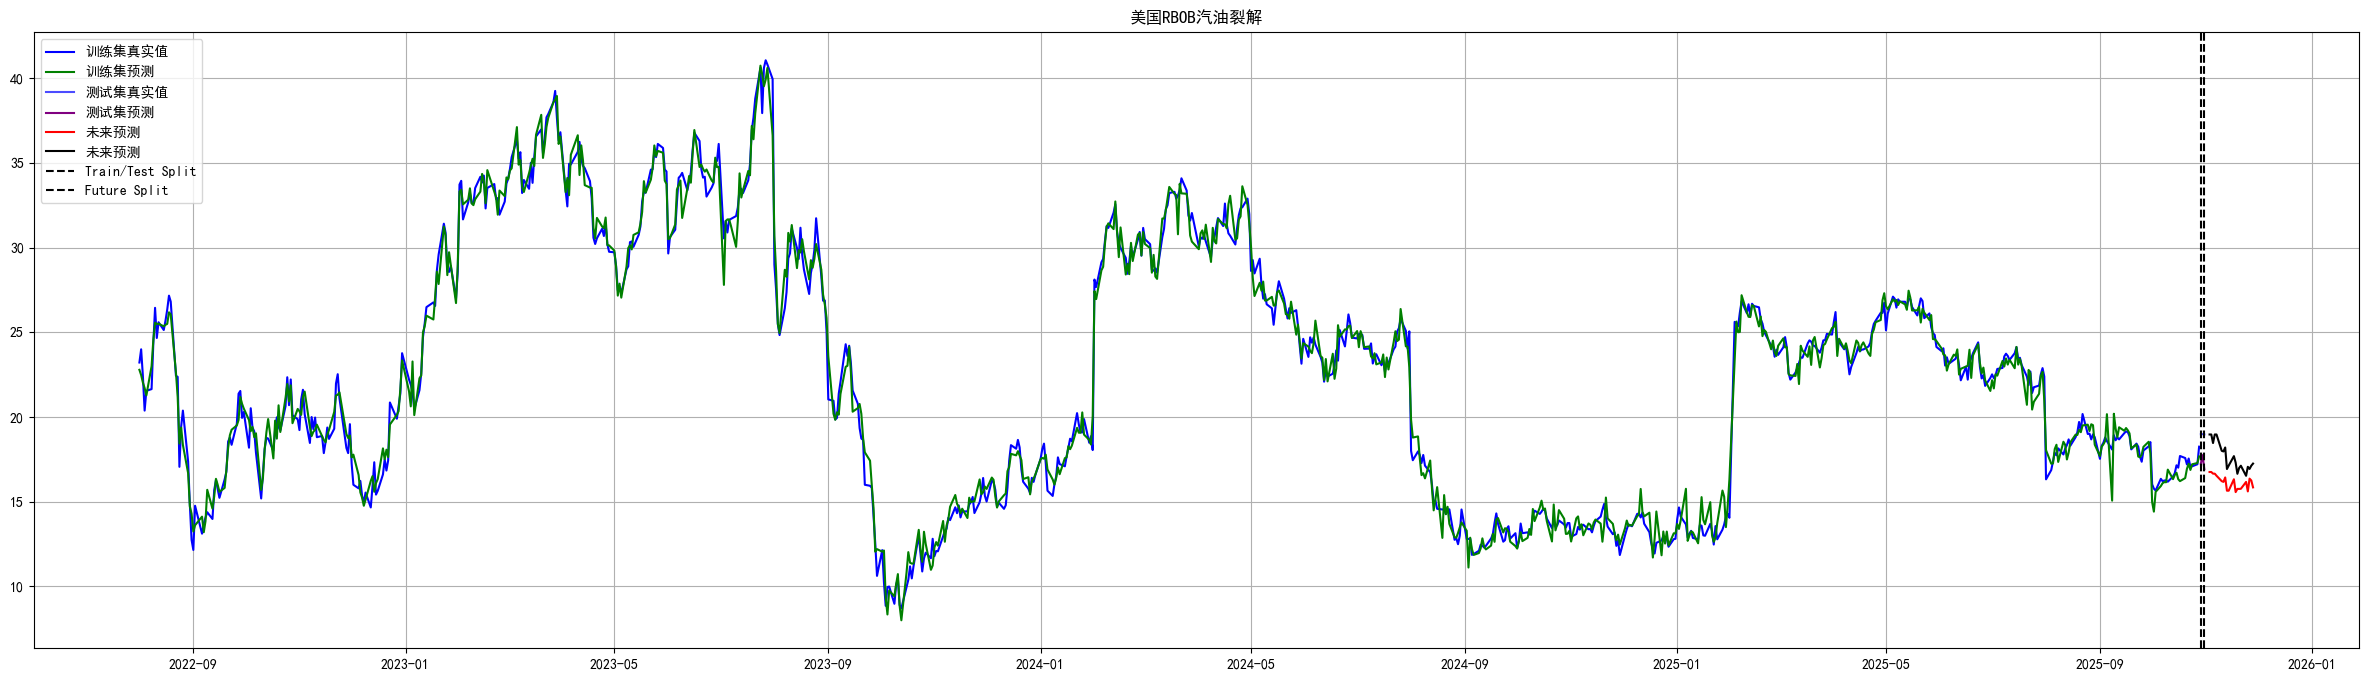

In [16]:
# 筛选2022年之后的数据
train_data_2022 = train_data[train_data['Date'] >= '2022-08-01']
test_data_2022 = test_data[test_data['Date'] >= '2022-08-01']
future_data_2022 = future_data[future_data['Date'] >= '2022-08-01']

# 可视化
plt.figure(figsize=(30, 8))

# 计算需要上移的距离
shift_distance = y_test[-len(test_data_2022):].iloc[-1] - future_data_2022['完整模型预测值'].iloc[0]

# 对完整模型预测值进行上移
future_data_2022['完整模型预测值'] = future_data_2022['完整模型预测值'] + shift_distance


# 画出筛选后的数据
plt.plot(train_data_2022['Date'], y_train[-len(train_data_2022):], label='训练集真实值', color='blue')
plt.plot(train_data_2022['Date'], y_train_pred_dmatrix[-len(train_data_2022):], label='训练集预测', color='green')

plt.plot(test_data_2022['Date'], y_test[-len(test_data_2022):], label='测试集真实值', color='blue', alpha=0.7)
plt.plot(test_data_2022['Date'], test_data_2022['预测值'], label='测试集预测', color='purple')

plt.plot(future_data_2022['Date'], future_data_2022['预测值'], label='未来预测', color='red')
plt.plot(future_data_2022['Date'], future_data_2022['完整模型预测值'] , label='未来预测', color='black')

# 分割线
plt.axvline(x=test_data_2022['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 图表信息
plt.title('美国RBOB汽油裂解')
plt.legend()
plt.grid(True)
plt.show()

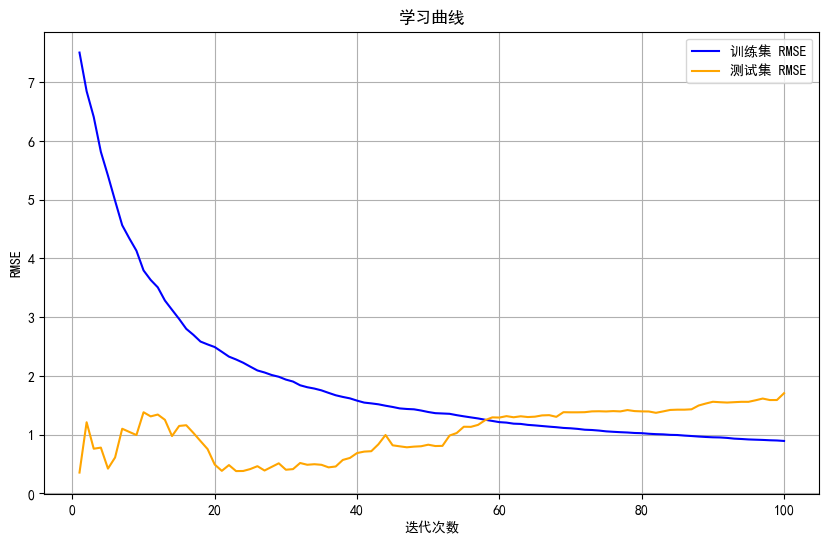

In [17]:
# 提取 RMSE 结果
train_rmse = evals_result['Train']['rmse']
test_rmse = evals_result['Test']['rmse']

# 绘制学习曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, label='训练集 RMSE', color='blue')
plt.plot(range(1, len(test_rmse) + 1), test_rmse, label='测试集 RMSE', color='orange')
plt.title("学习曲线")
plt.xlabel("迭代次数")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
'''
# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'gain'
feature_importance = xgb_model_dmatrix_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 gain')
plt.tight_layout()
plt.show()
'''


"\n# 创建特征重要性排序的DataFrame\nplt.figure(figsize=(12, 8))\nimportance_type = 'gain'\nfeature_importance = xgb_model_dmatrix_all.get_score(importance_type=importance_type)\n\nimportance_df = pd.DataFrame({\n    'feature': list(feature_importance.keys()),\n    'importance': list(feature_importance.values())\n})\n\n# 将特征名称从f0、f1等映射到实际的列名\nfeature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))\nimportance_df['feature_name'] = importance_df['feature'].map(feature_names)\n\n# 按重要性降序排序\nimportance_df_sorted = importance_df.sort_values('importance', ascending=True)\n\n# 绘制水平条形图\nplt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])\nplt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)\nplt.xlabel('特征重要性')\nplt.title('XGBoost因子重要性排序 gain')\nplt.tight_layout()\nplt.show()\n"

In [19]:
'''
# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'weight'
feature_importance = xgb_model_dmatrix_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 weight')
plt.tight_layout()
plt.show()
'''

"\n# 创建特征重要性排序的DataFrame\nplt.figure(figsize=(12, 8))\nimportance_type = 'weight'\nfeature_importance = xgb_model_dmatrix_all.get_score(importance_type=importance_type)\n\nimportance_df = pd.DataFrame({\n    'feature': list(feature_importance.keys()),\n    'importance': list(feature_importance.values())\n})\n\n# 将特征名称从f0、f1等映射到实际的列名\nfeature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))\nimportance_df['feature_name'] = importance_df['feature'].map(feature_names)\n\n# 按重要性降序排序\nimportance_df_sorted = importance_df.sort_values('importance', ascending=True)\n\n# 绘制水平条形图\nplt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])\nplt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)\nplt.xlabel('特征重要性')\nplt.title('XGBoost因子重要性排序 weight')\nplt.tight_layout()\nplt.show()\n"

In [20]:
'''
# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'cover'
feature_importance = xgb_model_dmatrix_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 cover')
plt.tight_layout()
plt.show()
'''

"\n# 创建特征重要性排序的DataFrame\nplt.figure(figsize=(12, 8))\nimportance_type = 'cover'\nfeature_importance = xgb_model_dmatrix_all.get_score(importance_type=importance_type)\n\nimportance_df = pd.DataFrame({\n    'feature': list(feature_importance.keys()),\n    'importance': list(feature_importance.values())\n})\n\n# 将特征名称从f0、f1等映射到实际的列名\nfeature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))\nimportance_df['feature_name'] = importance_df['feature'].map(feature_names)\n\n# 按重要性降序排序\nimportance_df_sorted = importance_df.sort_values('importance', ascending=True)\n\n# 绘制水平条形图\nplt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])\nplt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)\nplt.xlabel('特征重要性')\nplt.title('XGBoost因子重要性排序 cover')\nplt.tight_layout()\nplt.show()\n"

In [21]:
'''
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 确保 X_train_scaled 和 X_train 是 DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# 创建 SHAP Explainer
explainer = shap.Explainer(xgb_model_dmatrix_all, X_train_scaled_df)

# 计算 SHAP 值
shap_values = explainer(X_train_scaled_df)

# 提取 SHAP 值数组
shap_values_array = shap_values.values

# 绘制 SHAP Summary Plot
shap.summary_plot(
    shap_values_array,
    X_train,
    feature_names=X_train.columns,
    plot_size=(18, 6)  # 控制图形比例
)

'''

'\nimport shap\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\n# 确保 X_train_scaled 和 X_train 是 DataFrame\nX_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)\n\n# 创建 SHAP Explainer\nexplainer = shap.Explainer(xgb_model_dmatrix_all, X_train_scaled_df)\n\n# 计算 SHAP 值\nshap_values = explainer(X_train_scaled_df)\n\n# 提取 SHAP 值数组\nshap_values_array = shap_values.values\n\n# 绘制 SHAP Summary Plot\nshap.summary_plot(\n    shap_values_array,\n    X_train,\n    feature_names=X_train.columns,\n    plot_size=(18, 6)  # 控制图形比例\n)\n\n'

In [22]:
'''
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt

# 确保 X_train_scaled 是 numpy 数组
#X_train_scaled_np = np.array(X_train_scaled)
X_future_scaled_np = np.array(X_future_scaled)

# 创建 LIME 解释器（使用未标准化的数据）
explainer = LimeTabularExplainer(
    X_future_scaled_np,
#    X_train_scaled_np,
    feature_names=list(X_train.columns),  
    class_names=['预测值'],
    mode='regression',
    discretize_continuous=False  # 关闭离散化，避免 truncnorm 报错
)

# 选择一个样本进行解释（最后一个样本）
instance_idx = -1

#instance = X_train_scaled_np[instance_idx]
instance = X_future_scaled_np[instance_idx]


# 定义 XGBoost 预测函数
def predict_fn(x):
    dmatrix = xgb.DMatrix(x, feature_names=list(X_train.columns))  # 确保特征名称一致

#    return xgb_model_dmatrix.predict(dmatrix)
    return xgb_model_dmatrix_all.predict(dmatrix)

# 生成 LIME 解释
exp = explainer.explain_instance(
    instance, 
    predict_fn, 
    num_features=len(X_train.columns)
)

plt.rcParams.update({'font.size': 14})  # 调整字体大小
plt.figure(figsize=(20, 12))  # 增大图的宽度和高度
exp.as_pyplot_figure()
plt.title(f"LIME 特征贡献分析（样本 {instance_idx})")
plt.tight_layout()
plt.show()

# 打印详细特征贡献
print("\n特征贡献详情:")
for feature, importance in exp.as_list():
    print(f"{feature}: {importance:.4f}")

# 显示样本的预测值和真实值
predicted_value = predict_fn(instance.reshape(1, -1))[0]
#real_value = y_train.iloc[instance_idx]
print(f"\n预测值: {predicted_value:.4f}")
#print(f"真实值: {real_value:.4f}")
'''

'\nfrom lime.lime_tabular import LimeTabularExplainer\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# 确保 X_train_scaled 是 numpy 数组\n#X_train_scaled_np = np.array(X_train_scaled)\nX_future_scaled_np = np.array(X_future_scaled)\n\n# 创建 LIME 解释器（使用未标准化的数据）\nexplainer = LimeTabularExplainer(\n    X_future_scaled_np,\n#    X_train_scaled_np,\n    feature_names=list(X_train.columns),  \n    class_names=[\'预测值\'],\n    mode=\'regression\',\n    discretize_continuous=False  # 关闭离散化，避免 truncnorm 报错\n)\n\n# 选择一个样本进行解释（最后一个样本）\ninstance_idx = -1\n\n#instance = X_train_scaled_np[instance_idx]\ninstance = X_future_scaled_np[instance_idx]\n\n\n# 定义 XGBoost 预测函数\ndef predict_fn(x):\n    dmatrix = xgb.DMatrix(x, feature_names=list(X_train.columns))  # 确保特征名称一致\n\n#    return xgb_model_dmatrix.predict(dmatrix)\n    return xgb_model_dmatrix_all.predict(dmatrix)\n\n# 生成 LIME 解释\nexp = explainer.explain_instance(\n    instance, \n    predict_fn, \n    num_features=len(X_train.columns)\n)\n\nplt.

In [23]:
'''
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt

# 确保 X_train_scaled 是 numpy 数组
X_train_scaled_np = np.array(X_train_scaled)

# 创建 LIME 解释器（使用未标准化的数据）
explainer = LimeTabularExplainer(
    X_train_scaled_np,
    feature_names=list(X_train.columns),  
    class_names=['预测值'],
    mode='regression',
    discretize_continuous=False  # 关闭离散化，避免 truncnorm 报错
)

# 选择一个样本进行解释（最后一个样本）
instance_idx = -1

#instance = X_train_scaled_np[instance_idx]
instance = X_future_scaled_np[instance_idx]


# 定义 XGBoost 预测函数
def predict_fn(x):
    dmatrix = xgb.DMatrix(x, feature_names=list(X_train.columns))  # 确保特征名称一致

    return xgb_model_dmatrix.predict(dmatrix)

# 生成 LIME 解释
exp = explainer.explain_instance(
    instance, 
    predict_fn, 
    num_features=len(X_train.columns)
)

# 绘制 LIME 解释结果
plt.figure(figsize=(16, 10))
exp.as_pyplot_figure()
plt.title(f"LIME 特征贡献分析（样本 {instance_idx})")
plt.tight_layout()
plt.show()

# 打印详细特征贡献
print("\n特征贡献详情:")
for feature, importance in exp.as_list():
    print(f"{feature}: {importance:.4f}")

# 显示样本的预测值和真实值
predicted_value = predict_fn(instance.reshape(1, -1))[0]
real_value = y_train.iloc[instance_idx]
print(f"\n预测值: {predicted_value:.4f}")
print(f"真实值: {real_value:.4f}")
'''

'\nfrom lime.lime_tabular import LimeTabularExplainer\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# 确保 X_train_scaled 是 numpy 数组\nX_train_scaled_np = np.array(X_train_scaled)\n\n# 创建 LIME 解释器（使用未标准化的数据）\nexplainer = LimeTabularExplainer(\n    X_train_scaled_np,\n    feature_names=list(X_train.columns),  \n    class_names=[\'预测值\'],\n    mode=\'regression\',\n    discretize_continuous=False  # 关闭离散化，避免 truncnorm 报错\n)\n\n# 选择一个样本进行解释（最后一个样本）\ninstance_idx = -1\n\n#instance = X_train_scaled_np[instance_idx]\ninstance = X_future_scaled_np[instance_idx]\n\n\n# 定义 XGBoost 预测函数\ndef predict_fn(x):\n    dmatrix = xgb.DMatrix(x, feature_names=list(X_train.columns))  # 确保特征名称一致\n\n    return xgb_model_dmatrix.predict(dmatrix)\n\n# 生成 LIME 解释\nexp = explainer.explain_instance(\n    instance, \n    predict_fn, \n    num_features=len(X_train.columns)\n)\n\n# 绘制 LIME 解释结果\nplt.figure(figsize=(16, 10))\nexp.as_pyplot_figure()\nplt.title(f"LIME 特征贡献分析（样本 {instance_idx})")\nplt.tight_layou

In [24]:
'''
train_residual = y_train - y_train_pred_dmatrix
test_residual = y_test[-len(test_data_2022):] - test_data_2022['预测值']

# 绘制残差图
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_train_pred_dmatrix, train_residual, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('预测值')
plt.ylabel('残差')
plt.title('训练集残差图')

plt.subplot(1, 2, 2)
plt.scatter(test_data_2022['预测值'], test_residual, alpha=0.5, color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('预测值')
plt.ylabel('残差')
plt.title('测试集残差图')

plt.tight_layout()
plt.show()

# 绘制残差分布直方图
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(train_residual, bins=30, color='blue', alpha=0.7)
plt.title('训练集残差分布')
plt.xlabel('残差')
plt.ylabel('频数')

plt.subplot(1, 2, 2)
plt.hist(test_residual, bins=30, color='orange', alpha=0.7)
plt.title('测试集残差分布')
plt.xlabel('残差')
plt.ylabel('频数')

plt.tight_layout()
plt.show()

'''

"\ntrain_residual = y_train - y_train_pred_dmatrix\ntest_residual = y_test[-len(test_data_2022):] - test_data_2022['预测值']\n\n# 绘制残差图\nplt.figure(figsize=(10, 4))\n\nplt.subplot(1, 2, 1)\nplt.scatter(y_train_pred_dmatrix, train_residual, alpha=0.5)\nplt.axhline(y=0, color='r', linestyle='--')\nplt.xlabel('预测值')\nplt.ylabel('残差')\nplt.title('训练集残差图')\n\nplt.subplot(1, 2, 2)\nplt.scatter(test_data_2022['预测值'], test_residual, alpha=0.5, color='orange')\nplt.axhline(y=0, color='r', linestyle='--')\nplt.xlabel('预测值')\nplt.ylabel('残差')\nplt.title('测试集残差图')\n\nplt.tight_layout()\nplt.show()\n\n# 绘制残差分布直方图\nplt.figure(figsize=(10, 4))\n\nplt.subplot(1, 2, 1)\nplt.hist(train_residual, bins=30, color='blue', alpha=0.7)\nplt.title('训练集残差分布')\nplt.xlabel('残差')\nplt.ylabel('频数')\n\nplt.subplot(1, 2, 2)\nplt.hist(test_residual, bins=30, color='orange', alpha=0.7)\nplt.title('测试集残差分布')\nplt.xlabel('残差')\nplt.ylabel('频数')\n\nplt.tight_layout()\nplt.show()\n\n"

---

In [25]:
'''
# 取红线 训练集 训练出来的模型 预测
real_rbob = sheet_daily[['Date', '美国RBOB汽油裂解']]
predictions_rbob = future_data_2022[['Date', '预测值']]
merged_rbob = pd.merge(real_rbob, predictions_rbob, on='Date', how='left')

merged_rbob['美国RBOB汽油裂解'] = merged_rbob['美国RBOB汽油裂解'].combine_first(merged_rbob['预测值'])
final_rbob = merged_rbob[['Date', '美国RBOB汽油裂解']]

final_rbob.to_excel('data_input_auto/predictions_rbob.xlsx', index=False)
print("数据已保存为 'predictions_rbob.xlsx'")
'''

'\n# 取红线 训练集 训练出来的模型 预测\nreal_rbob = sheet_daily[[\'Date\', \'美国RBOB汽油裂解\']]\npredictions_rbob = future_data_2022[[\'Date\', \'预测值\']]\nmerged_rbob = pd.merge(real_rbob, predictions_rbob, on=\'Date\', how=\'left\')\n\nmerged_rbob[\'美国RBOB汽油裂解\'] = merged_rbob[\'美国RBOB汽油裂解\'].combine_first(merged_rbob[\'预测值\'])\nfinal_rbob = merged_rbob[[\'Date\', \'美国RBOB汽油裂解\']]\n\nfinal_rbob.to_excel(\'data_input_auto/predictions_rbob.xlsx\', index=False)\nprint("数据已保存为 \'predictions_rbob.xlsx\'")\n'

In [26]:
# 取黑线 所有数据训练出来的 模型预测
real_rbob = sheet_daily[['Date', '美国RBOB汽油裂解']]
predictions_rbob = future_data_2022[['Date', '完整模型预测值']]
merged_rbob = pd.merge(real_rbob, predictions_rbob, on='Date', how='left')

merged_rbob['美国RBOB汽油裂解'] = merged_rbob['美国RBOB汽油裂解'].combine_first(merged_rbob['完整模型预测值'])
final_rbob = merged_rbob[['Date', '美国RBOB汽油裂解']]

final_rbob.to_excel('data_input_auto/predictions_rbob.xlsx', index=False)
print("数据已保存为 'predictions_rbob.xlsx'")

数据已保存为 'predictions_rbob.xlsx'


In [27]:
# 创建一个空的DataFrame用于存储合并后的月度数据
final_rbob_monthly = pd.DataFrame()

# 获取2023年以后的训练集预测数据
train_pred_2023 = train_data_2022[train_data_2022['Date'].dt.year >= 2023].copy()
train_pred_2023['美国RBOB汽油裂解'] = y_train_pred_dmatrix[-len(train_data_2022):][train_data_2022['Date'].dt.year >= 2023]

# 获取测试集预测数据
test_pred = test_data_2022[['Date', '预测值']].copy()
test_pred.rename(columns={'预测值': '美国RBOB汽油裂解'}, inplace=True)

# 获取未来预测数据
future_pred = future_data_2022[['Date', '完整模型预测值']].copy()
future_pred.rename(columns={'完整模型预测值': '美国RBOB汽油裂解'}, inplace=True)

# 合并所有数据
final_rbob_monthly = pd.concat([
    train_pred_2023[['Date', '美国RBOB汽油裂解']],
    test_pred,
    future_pred
], ignore_index=True)

# 确保日期格式正确
final_rbob_monthly['Date'] = pd.to_datetime(final_rbob_monthly['Date'])

# 按月份分组并获取每月最后一天的数据
final_rbob_monthly = final_rbob_monthly.groupby(pd.Grouper(key='Date', freq='ME')).last().reset_index()

# 按日期排序
final_rbob_monthly = final_rbob_monthly.sort_values('Date', ascending=False)

# 重新保存倒序后的数据
final_rbob_monthly.to_excel('data_output_eta/predictions_rbob_monthly.xlsx', index=False)
print("倒序数据已保存为 'predictions_rbob_monthly.xlsx'")

倒序数据已保存为 'predictions_rbob_monthly.xlsx'


---

In [28]:
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', '美国RBOB汽油裂解']]
test_actual = test_data[['Date', '美国RBOB汽油裂解']]

# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']

# 获取historical_actual最后一个值
last_actual_value = historical_actual.iloc[-1]['实际值']
# 将future_pred的第一个值设置为historical_actual的最后一个值
future_pred.iloc[0, future_pred.columns.get_loc('美国RBOB汽油裂解')] = last_actual_value

# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)

merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')

# 保存到Excel
merged_df.to_excel('eta/美国RBOB汽油裂解_合并数据.xlsx', index=False, float_format='%.2f')
merged_df

C:\Users\Hz\AppData\Local\Temp\ipykernel_12096\1083513520.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.97' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  future_pred.iloc[0, future_pred.columns.get_loc('美国RBOB汽油裂解')] = last_actual_value


,Date,实际值,美国RBOB汽油裂解
754,2025/11/28,NaN,17.250608
753,2025/11/27,NaN,17.127598
752,2025/11/26,NaN,16.935452
751,2025/11/25,NaN,17.060787
750,2025/11/24,NaN,16.529531
...,...,...,...
4,2023/01/09,21.59,NaN
3,2023/01/06,20.46,NaN
2,2023/01/05,21.49,NaN
1,2023/01/04,21.91,NaN


In [29]:
# 任务2: 生成月度数据
# 获取2023年以后的实际值
actual_values = pd.concat([
    train_data[train_data['Date'].dt.year >= 2023][['Date', '美国RBOB汽油裂解']],
    test_data[['Date', '美国RBOB汽油裂解']]
])
actual_values.columns = ['Date', '实际值']

# 创建包含2024年及以后训练集预测值的DataFrame
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})

future_pred1 = future_pred.rename(columns={'美国RBOB汽油裂解': '预测值'})


# 重新构建predictions DataFrame # 
predictions = pd.concat([
    train_pred_2024,
    test_data[['Date', '预测值']],
    future_pred1
], ignore_index=True)

# 重新合并实际值和预测值
monthly_df = pd.merge(actual_values, predictions, on='Date', how='outer')

# 转换为月度数据
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.set_index('Date', inplace=True)
monthly_df = monthly_df.resample('ME').mean()
monthly_df.reset_index(inplace=True)
monthly_df = monthly_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y/%m/%d')


# 保存月度数据
monthly_df.to_excel('eta/美国RBOB汽油裂解_月度数据.xlsx', index=False, float_format='%.2f')

monthly_df.head()

,Date,实际值,预测值
34,2025/11/30,NaN,17.662363
33,2025/10/31,17.070000,16.517701
32,2025/09/30,18.435909,18.495174
31,2025/08/31,18.431429,18.529218
30,2025/07/31,22.827826,22.457409


---

In [30]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "美国RBOB汽油裂解"

# 调用函数更新数据
success = update_excel_data(merged_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [31]:
from Lcel import update_excel_data
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "详情页"
identifier = "美国RBOB汽油裂解"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
